## Hypothesis
Using batch normalisation helps training by preventing the internal covariate shift and allows for higher learning rates and less careful initialisations.
While it is standard practice to use batch normalisation on all layers, we suspect most of its benefits can be yielded by implementing in only on a subset of the layers.

##Setup

We are going to be testing our hypothesis while training a multi-class classifier on the MNIST dataset.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

# download and transform train dataset
train_loader = torch.utils.data.DataLoader(datasets.MNIST('../../Data/mnist_data', download=True, train=True, transform=transforms.Compose([
transforms.ToTensor(), # first, convert image to PyTorch tensor
transforms.Normalize((0.1307,), (0.3081,)) ])), 
batch_size=128, shuffle=True)

# download and transform test dataset
test_loader = torch.utils.data.DataLoader(datasets.MNIST('../../Data/mnist_data', download=True, train=False,transform=transforms.Compose([
transforms.ToTensor(), # first, convert image to PyTorch tensor
transforms.Normalize((0.1307,), (0.3081,)) ])), 
batch_size=128, shuffle=True)

##Defining the network
We are implementing a convolutional neural network with two convolutional and two fully connected layers. (~LeNet-5)

We achieve the selective batch normalisations by passing a list of booleans to the classifier when initialising, however unelegant of a solution that is :).

In [ ]:
class CNNClassifier(nn.Module):
    normlayers = []
    def __init__(self, normlayers=[True, True, True, True]):
        self.normlayers = normlayers
        
        super(CNNClassifier, self).__init__()
        #two convolutional layers
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2, bias= False)
        if(normlayers[0]):
          self.conv1_bn = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, bias= False)
        if(normlayers[1]):
          self.conv2_bn = nn.BatchNorm2d(32)
        
        #fully connected layers
        self.fc1 = nn.Linear(32*5*5, 120, bias= False)
        if(normlayers[2]):
          self.fc1_bn = nn.BatchNorm1d(120)
        
        self.fc2 = nn.Linear(120, 84, bias= False)
        if(normlayers[3]):
          self.fc2_bn = nn.BatchNorm1d(84)
        
        self.fc3 = nn.Linear(84, 10)
      
           
    def forward(self, x):
                #definition of the forward pass
                x=self.conv1(x)
                if(self.normlayers[0]):
                  x=self.conv1_bn(x)
                x=F.max_pool2d(x, 2 ,2)
                x = F.relu(x)
                
                x=self.conv2(x)
                if(self.normlayers[1]):
                  x=self.conv2_bn(x)
                x=F.max_pool2d(x, 2 ,2)
                x = F.relu(x)
                
                x= x.view(-1,32*5*5)
                
                x=self.fc1(x)
                if(self.normlayers[2]):
                  x=self.fc1_bn(x)
                x = F.relu(x)
                
                x=self.fc2(x)
                if(self.normlayers[3]):
                  x=self.fc2_bn(x)
                x = F.relu(x)
                
                x=self.fc3(x)
                
                
                return F.log_softmax(x,-1)

In [ ]:
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []
criterion1 = nn.CrossEntropyLoss()

# a cosmetic function for compulsive reasons, skip
def pad(num, l):
  s = str(num)[:l]
  return(s + ' ' * (l - len(s)))

In [ ]:
def train(epoch):
    #training for one epoch
    #reading data
    for batch_id, (data, label) in enumerate(train_loader):
        clf.train() #set the net to train mode
        data=data.cuda() #put data on gpu
        label=label.cuda()
        opt.zero_grad()
        preds = clf(data) #execute forward pass
        #calculate loss
        loss = torch.diag(preds[:,label])
        loss =  -torch.mean(loss)
        loss.backward() #backward pass
        train_loss_history[-1].append(loss.item())
        opt.step() #update parameters
        #calculate accuracy
        predind = preds.data.max(1)[1] 
        acc = predind.eq(label.data).cpu().float().mean() 
        train_acc_history[-1].append(acc)
        
        if batch_id % 20 == 0: # changed from 100 to 20 temporarily
            metrics = "Train Loss: " + pad(loss.item(), 7) + " Acc: " + pad(acc.item(), 4)

            #run independent test
            clf.eval() # set model in inference mode (need this because of dropout)
            test_loss = 0
            correct = 0
        
            for data, target in test_loader: 
                data=data.cuda()
                target=target.cuda()  
                with torch.no_grad():    
                   output = clf(data)
                   test_loss += F.nll_loss(output, target).item()
                   pred = output.data.max(1)[1] 
                   correct += pred.eq(target.data).cpu().sum()

            test_loss = test_loss
            test_loss /= len(test_loader) # loss function already averages over batch size
            accuracy =  correct.item() / len(test_loader.dataset)
            test_acc_history[-1].append(accuracy)
            test_loss_history[-1].append(test_loss)
            metrics += "  |  Test Loss: " + pad(test_loss, 7) + " Acc: " + pad(accuracy, 4)
            print(metrics)

In [ ]:
# execute training N times, with normalizations where specified
# this is the training procedure as opposed to a single training step
# (I tend to be bad with naming functions.)
def run_training(N=10, normlayers=[True, True, True, True]):
  global clf, opt
  for repeat in range(0, 1):
      clf = CNNClassifier(normlayers)
      clf.cuda()
      opt = optim.SGD(clf.parameters(), lr=0.01, momentum=0.5)
      train_loss_history.append([])
      train_acc_history.append([])
      test_loss_history.append([])
      test_acc_history.append([])
      for epoch in range(0, N):
          print("Epoch %d" % epoch)
          train(epoch)

##The experiment
Here we have a few subsets of the 2^4 possible boolean lists. We define the experiment function which allows us to compare training processes by specifying a subset of all possible settings and the number of epochs to train (this is to moderate the length of experiments when training many networks).

In [ ]:
# arrays of settings to use later
all_binaries = [[False, False, False, False],
            [False, False, False, True],
            [False, False, True, False],
            [False, True, False, False],
            [True, False, False, False],
            [False, False, True, True],
            [False, True, False, True],
            [True, False, False, True],
            [False, True, True, False],
            [True, False, True, False],
            [True, True, False, False],
            [False, True, True, True],
            [True, False, True, True],
            [True, True, False, True],
            [True, True, True, False],
            [True, True, True, True]]
            
selection = [[False, False, False, False],
            [False, True, False, False],
            [False, True, True, False],
            [True, False, True, False],
            [True, True, False, False],
            [True, True, True, True]]

extremes = [[False, False, False, False],
            [True, True, True, True]]
             

In [ ]:
# train the network with a specific set of normalisation settings, for N epochs each.
def experiment(epochs, norm_settings):
  for list in norm_settings:
    print('\nTraining with ' + str(list))
    run_training(epochs, list)

In [ ]:
test_acc_history = []
experiment(1, selection)


Training with [False, False, False, False]
Epoch 0
Train Loss: 2.30011 Acc: 0.14  |  Test Loss: 2.30521 Acc: 0.10
Train Loss: 2.29449 Acc: 0.07  |  Test Loss: 2.29207 Acc: 0.10
Train Loss: 2.28308 Acc: 0.07  |  Test Loss: 2.28043 Acc: 0.10
Train Loss: 2.26180 Acc: 0.17  |  Test Loss: 2.26429 Acc: 0.16
Train Loss: 2.24708 Acc: 0.25  |  Test Loss: 2.23853 Acc: 0.28
Train Loss: 2.20156 Acc: 0.32  |  Test Loss: 2.19042 Acc: 0.34
Train Loss: 2.10385 Acc: 0.5   |  Test Loss: 2.08708 Acc: 0.53
Train Loss: 1.82270 Acc: 0.79  |  Test Loss: 1.81526 Acc: 0.72
Train Loss: 1.17101 Acc: 0.81  |  Test Loss: 1.19872 Acc: 0.75
Train Loss: 0.75288 Acc: 0.82  |  Test Loss: 0.78352 Acc: 0.76
Train Loss: 0.68296 Acc: 0.76  |  Test Loss: 0.62545 Acc: 0.79
Train Loss: 0.55519 Acc: 0.84  |  Test Loss: 0.50952 Acc: 0.84
Train Loss: 0.49709 Acc: 0.89  |  Test Loss: 0.46147 Acc: 0.86
Train Loss: 0.51008 Acc: 0.82  |  Test Loss: 0.43418 Acc: 0.86
Train Loss: 0.29052 Acc: 0.87  |  Test Loss: 0.41152 Acc: 0.87
Tra

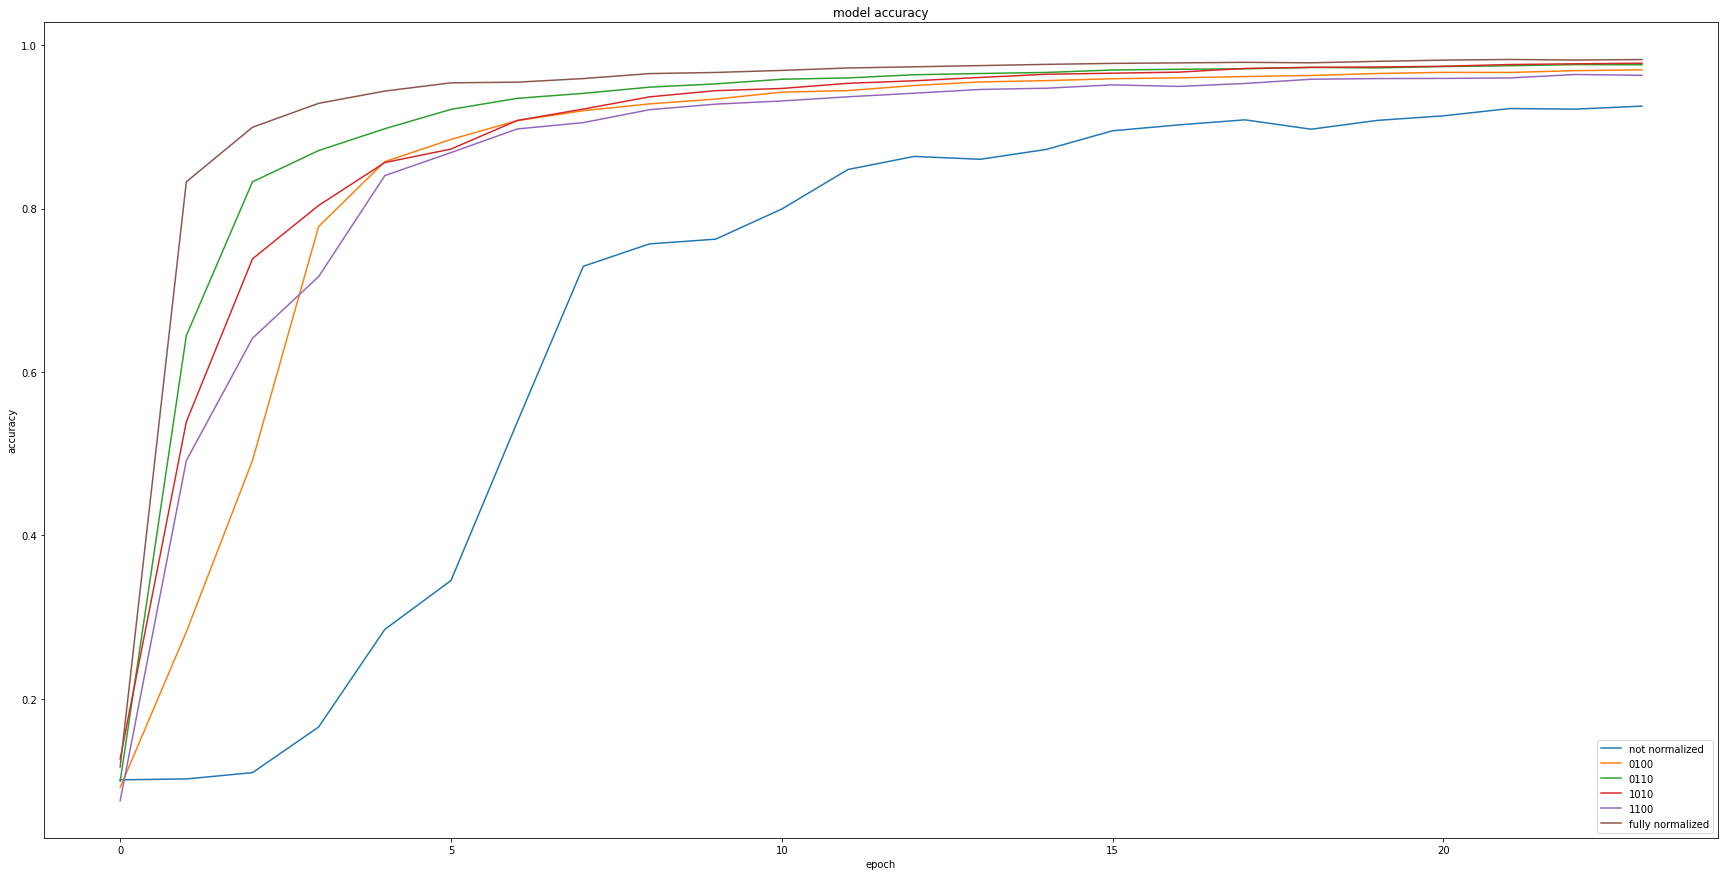

In [ ]:
plt.rcParams['figure.figsize'] = (30,15)
for a in test_acc_history:
  plt.plot(range(len(a)), a)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['not normalized', '0100', '0110', '1010', '1100', 'fully normalized'], loc='lower right')
plt.show()

##First Impressions

We can see that by normalising just 1 of 4 layers, we can obtain much of the benefits (~75% judging from the first plot) of a fully normalised network in the early training steps. Naturally, the results improve further when normalising 2.
The most efficient setting seems to be the [0110] one, that is, when applying batch norm in the middle layers.

Below is the test accuracy for certain configurations (sampled after every 100th batch)
![Plot](https://drive.google.com/uc?id=1k9DUxCcOHq2hBStiAiZsRS5-C-t7Oa-x)

Here we can see the same configurations but with greater granularity (after every 20th batch). It is apparent that Green [0110] follows closely in the fully normalised network's footsteps, with Red [1010] converging similarly quickly. 
![Plot](https://drive.google.com/uc?id=1A4kzQp4g11V6P5lbSW9YD4M1_lasLD1I)

Although it not our specific goal to converge as quickly as possible, we can assume that those configurations that are held back by the covariate shift will not overperform those that converge faster - they are, after all, converging to the same state, only slower.

I will later compare how much training it took each configuration to reach a reliable accuracy, say, 0.97 in a consistent manner.